<a href="https://colab.research.google.com/github/mdhabibi/Variational_AutoEncoders/blob/main/End_to_End_beta_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The End-to-End $\beta$-Variational Autoencoder (VAE) for MNIST Dataset**

The provided script includes the required code for the creation, training, and evaluation of a **$\beta$-Variational Autoencoder (VAE)** using the MNIST dataset. The MNIST dataset comprises grayscale images of handwritten digits ranging from `0` to `9`, with each image having dimensions of `28` by `28` pixels. The **Keras** framework was employed in this project.


The core structure of a variational autoencoder comprises five components, as illustrated in the diagram sourced from Wikipedia.
![VAE_Basic](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/640px-VAE_Basic.png?download)


**Step-01: Importing required modules**

In [ ]:
import numpy as np                          # Used for handling large data arrays
import matplotlib.pyplot as plt             # Used for creating visualizations
from matplotlib.colors import ListedColormap
import seaborn as sns

import keras                                # High-level neural networks API

from   keras.datasets import mnist          # Dataset of hand-written digits
# Various building blocks for neural networks
from   keras.layers    import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from   keras.models    import Model         # Used for defining and training models

# For better control of the training process
from   keras.callbacks import EarlyStopping, ModelCheckpoint

from   keras import backend as K
# Note: The backend above provides a bridge between Keras and
# its underlying computation libraries, such as TensorFlow.




---


# **(1) INPUT**


---



**Step-02: Loading the MNIST dataset**

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train and x_test are arrays of image data, and y_train and y_test are arrays of digit labels (0-9).

**Step-03: Data Preprocessing**

In [ ]:
# Check the type of elements in x_train.
print(x_train.dtype)
print(x_train.shape)

uint8
(60000, 28, 28)


**Note:** If print(x_train.dtype) outputs uint8, it means that the elements in the x_train array are of the type "unsigned 8-bit integer". In practical terms, an uint8 data type can represent integers ranging from $0$ to $255$ (inclusive). This is a common format for image data where the intensity of each color channel (red, green, blue) in each pixel is represented as an integer from $0$ (no intensity) to $255$ (maximum intensity).

So, if x_train is coming from an image dataset like MNIST, each element of x_train is an integer between $0$ and $255$ representing the grayscale intensity of a pixel in an image.

Neural networks usually perform better with floating point numbers, and work better with data in a normalized form, i.e., in the range of $0-1$. Converting the data type to 'float32' allows us to perform this normalization

1.   Converting and Normalizating

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.

In [ ]:
# Check again the type of elements in x_train after normalization.
print(x_train.dtype)
print(x_train.shape)

float32
(60000, 28, 28)


2.   Retrieving the original width and height of the images in the MNIST dataset

In [ ]:
img_num_train = x_train.shape[0]
img_width     = x_train.shape[1]
img_height    = x_train.shape[2]

print(f"The MNIST train set contains {img_num_train} images, each with dimensions:"
      f"\n(width x height) = ({img_width} x {img_height}) pixels.")

img_num_test  = x_test.shape[0]
print(f"The MNIST test set also contains {img_num_train} images with the same dismension as the train.")

The MNIST train set contains 60000 images, each with dimensions:
(width x height) = (28 x 28) pixels.
The MNIST test set also contains 60000 images with the same dismension as the train.


3.   Reshaping Image Data for Convolutional Neural Network Input:

**Note**: Keras, along with various other machine learning libraries, requires images to be converted to a specific format indicated by the shape (height, width, channels). In this context, the term "channels" refers to the number of color channels present in the image.  Hence, it is essential to modify the dimensions of the images. It is important to note that the MNIST images used in this task are grayscale, meaning they consist of only one channel.

In [ ]:
num_channels = 1

# Reshaping the training and test datasets to have a 4D tensor representing the number of channels
x_train = x_train.reshape(img_num_train, img_height, img_width, num_channels)
x_test  = x_test .reshape(img_num_test , img_height, img_width, num_channels)

# Defining the shape of the input data which will be used to configure the neural network
input_dimensions = (img_height, img_width, num_channels)

print(f"Dimensions of each image that will be fed into the model are"
      f"\n(img_height, img_width, num_channels)={input_dimensions}.")
print(x_train.shape)

Dimensions of each image that will be fed into the model are
(img_height, img_width, num_channels)=(28, 28, 1).
(60000, 28, 28, 1)


4.   Visualizing the data to see a few arbitrary images (Only for checking!)

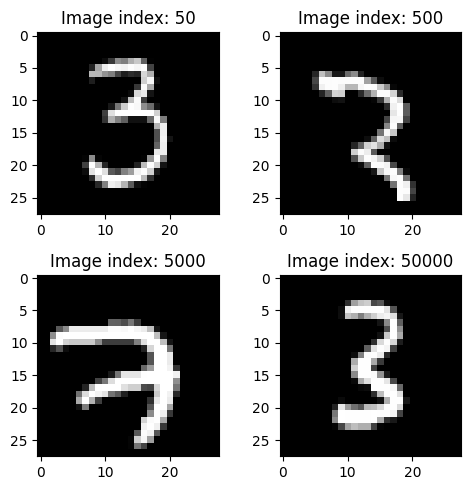

In [ ]:
# Define indices of images to be viewed (Arbitrary indices)
image_indices = [50, 500, 5000, 50000]

# Set up the figure
plt.figure(figsize = (5, 5))

for i, img_index in enumerate(image_indices):
    plt.subplot(2, 2, i+1)
    plt.imshow (x_train[img_index][:,:,0], cmap = 'gray')  # default cmap in imshow is 'viridis'
    plt.title  (f'Image index: {img_index}')

plt.tight_layout()
plt.show()




---


#**(2) Encoder**


---



In this part of VAE algorithm, I take the images, processes it with several convolutional layers, flatten the output, processe it with a dense layer, and finally output the parameters of a probability distribution: a mean and a standard deviation in a 10D latent space.

In [ ]:
# Setting up the latent dimension
# The latent dimension is the number of dimensions in the space that the encoder compresses the input into.
# Note that I have chosen 10 for dimensions here. This matches with the number of unique digits (0-9) in the dataset.
latent_space_dim = 10

*   Defining the input layer for the encoder

In [ ]:
# It creates an input layer for the encoder where the shape of the input data is specified.
encoder_input_layer = Input(shape = input_dimensions, name = 'encoder_input_layer')

*   Convolution layers

In [ ]:
# Conv2D(filters, kernel_size, strides, padding, activation)

encoder_layer = Conv2D(32, 3, padding='same', activation='relu')(encoder_input_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu', strides = (2, 2))(encoder_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu')(encoder_layer)

**Note:**
The strides parameter in convolutional layers of a neural network determines the step size or the "jump" the filter makes across the image or volume.
 Stride is a two-element tuple that specifies the step size in the vertical and horizontal directions, respectively.
 Here, the convolutional filter moves 2 pixels at a time as it slides along the input matrix, both in the height and width dimensions

In [ ]:
# The shape of the tensor x (i.e., conv_shape) is stored because it will be used later
# in the code when building the decoder part of the VAE.
# This allows the decoder to start its reconstruction process from a tensor that
# has the same shape as the output tensor of the encoder.

encoder_output_shape = K.int_shape(encoder_layer)

print(f"The shape of the tensor at the output of the encoder"
      f"\n(and the input to the decoder) is: {encoder_output_shape}")

The shape of the tensor at the output of the encoder
(and the input to the decoder) is: (None, 14, 14, 64)


**Note:** The number of batch size here is specified by 'None' which simply allows us to specify this later in the training step.

 This shape tells us that for each batch of input images, the encoder will produce a tensor where each image is represented as a 14x14x64 tensor (a 3D volume of 64 feature maps, each of size 14x14).

*   Flattening the 3D output from the convolutional layers

In [ ]:
# The output from the convolutional layers is a 3D tensor (height, width, channels) for each image.
# However, the following layers (dense layers) expect input as a 1D tensor per image in the batch.
# Therefore, we need to flatten the 3D tensor into a 1D tensor using Flatten()(encoder_stage4).

encoder_layer = Flatten()(encoder_layer)
print(encoder_layer.shape)

(None, 12544)


*   Adding a Dense layer

In [ ]:
# After extracting features through convolutional layers and flattening, we use a Dense layer.
# This layer learns to recognize patterns by combining the features extracted from the previous layers.
# The Dense layer is a type of layer that performs a linear operation on its input,
# followed by an activation function.

encoder_layer = Dense(32, activation = 'relu')(encoder_layer)
print(encoder_layer.shape)

(None, 32)


*   Output layer

 A crucial transition between the encoder and the latent space (the final step of the encoder and the first step of defining the latent space in a VAE).

**Note:** The purpose of the VAE is not just to encode and then decode the input. It is to encode the input into a representation that **approximates** a specified probability distribution, usually a normal distribution. The mean and standard deviation can represent parameters of a normal distribution. This normal distribution is used to generate the encoded representation of the input data, and is the distribution we want the encoded representations to approximate.

In [ ]:
# Creating two Dense layers to generate the parameters of the probability distribution of the latent space.
# One Dense layer (mu_layer) for the means, and another Dense layer (sigma_layer) for the standard deviations.

mu_layer    = Dense(latent_space_dim, name = 'latent_mu')(encoder_layer)

sigma_layer = Dense(latent_space_dim, name = 'latent_sigma')(encoder_layer)

#print(f"mu_layer shape: {mu_layer.shape}, sigma_layer shape: {sigma_layer.shape}")



---


#**(3) Latent space:**


---



**Reparameterization trick**

When we want to sample a point from the normal (Gaussian) distribution defined by $\mu$ and $\sigma$, we use a random process. This random process is not differentiable, which means we can't compute gradients through it to calculate loss function. And since backpropagation, the mechanism by which neural networks are trained, requires computing gradients, this presents a problem.

The reparameterization trick is a clever way around this problem. Instead of directly sampling from the distribution defined by $\mu$ and $\sigma$, we sample (choose a random number) from a standard normal distribution ($\mu=0$ and $\sigma=1$), and then we shift (add $\mu$) and scale (multiply by $\sigma$) this sampled point. This new method for generating $z$, ($z = \mu + \sigma * \epsilon$), is differentiable with respect to $\mu$ and $\sigma$ because it does not involve sampling $\mu$ and $\sigma$ directly.

In [ ]:
def sample_z(args):
    """Generate a sample from the Gaussian distribution defined by args=(mu, sigma).

    Args:
    mu_layer:    The mean of the Gaussian distribution.
    sigma_layer: The log standard deviation of the Gaussian distribution.

    Returns:
    A sample from the Gaussian distribution.
    """
    mu_layer, sigma_layer = args
    batch_size = K.shape(mu_layer)[0]
    # print(batch_size)
    dim = K.int_shape(mu_layer)[1]

    # Generate a random sample from a standard normal distribution with the same shape
    epsilon = K.random_normal(shape = (batch_size, dim))

    # Scale and shift the sample by mu and sigma to create a sample from the original Gaussian distribution
    return mu_layer + K.exp(sigma_layer / 2) * epsilon


**Creating a new layer z:**

In [ ]:
z = Lambda(sample_z, output_shape = (latent_space_dim, ), name = 'z')([mu_layer, sigma_layer])

**Note:** Here Lambda is not the lambda function from Python's standard library. Instead, it's a type of layer in Keras, specifically keras.layers.Lambda. It's used to apply an arbitrary function to the output of a layer.



---



---



#**Encoder Model**

To encapsulate the encoder part of the VAE into a standalone model that can be trained and used independently.

In [ ]:
# Model(encoder_input_layer, output, name)
encoder_model = Model(encoder_input_layer, [mu_layer, sigma_layer, z], name = 'encoder_model')

# Save the model
encoder_model.save('encoder_model_MNIST.h5')

In [ ]:
print(encoder_model.summary())

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input_layer (InputLaye  [(None, 28, 28, 1)]  0          []                               
 r)                                                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input_layer[0][0]']    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']   

**Note:**



*   Param # column shows the number of trainable parameters for each layer. The
number of parameters is given by $(n*m*l+1)*k$ where $n$ and $m$ are the dimensions of the filter size, $l$ is the number of input channels to the layer, and $k$ is the number of filters in the layer. The $"+1"$ is for the bias term for each filter. So, for instance, for the first Conv2D layer in my model (conv2d), we have $(3*3*1+1)*32 = 320$ parameters, since the layer uses $32$ filters of size $3\times 3$, and the input has $1$ channel.



*   The number of parameters in a Dense layer is given by $(n+1)*m$, where $n$ is the number of neurons in the previous layer (or the number of elements in the input vector for the first Dense layer following the input), and $m$ is the number of neurons in the Dense layer. The $"+1"$ is for the bias term for each neuron. So, for the Dense layer in your model (dense), there are $(12544+1)*32 = 401440$ parameters.



*   Input, Flatten, and Lambda layers: These types of layers don't have any
trainable parameters, hence the $'0'$ in the Param # column.



---


#**(4) Decoder**


---



In [ ]:
# It creates an input layer for the decoder where the shape of the input data is specified by the latent space dimension.
decoder_input_layer = Input(shape = (latent_space_dim, ), name = 'decoder_input_layer')



*   The first layer of decoding



In [ ]:
# The Dense layer performs a linear operation on the layer's input,
# transforming it into a space of dimension equal to the number of its units.
num_units = encoder_output_shape[1] * encoder_output_shape[2] * encoder_output_shape[3]
decoder_dense_layer = Dense(num_units, activation='relu')(decoder_input_layer)
print(f"Shape of the initial dense layer in the decoder: {decoder_dense_layer.shape}")

Shape of the initial dense layer in the decoder: (None, 12544)




*   Reshaping





In this line of code, the output of the Dense layer in the decoder, which is a flat vector, is reshaped back to the shape of the output from the last Conv2D layer in the encoder part.

In [ ]:
reshape_dims = (encoder_output_shape[1], encoder_output_shape[2], encoder_output_shape[3])
decoder_reshape_layer = Reshape(reshape_dims)(decoder_dense_layer)
print(f"Shape of the reshaped layer in the decoder: {decoder_reshape_layer.shape}")
# Compare it with dimension of conv2d_3 (Conv2D)

Shape of the reshaped layer in the decoder: (None, 14, 14, 64)


**Note:** The reshaping is necessary because after this point, the decoder will use convolutional layers (likely Conv2DTranspose or UpSampling2D + Conv2D layers) to progressively upsample the data back to the shape of the original input image. These convolutional layers require input data with the same number of dimensions as their output data, which is why the output of the Dense layer needs to be reshaped.



*   Deconvolution



In [ ]:
# Define the configuration for the first upsampling layer in the decoder
upsample_layer_config = {'filters': 32,
                         'kernel_size': 3,
                         'padding': 'same',
                         'activation': 'relu',
                         'strides': (2, 2)
                         }

# Add the first upsampling layer to the decoder using the above configuration
decoder_upsample_layer = Conv2DTranspose(**upsample_layer_config)(decoder_reshape_layer)
print(f"Shape of the first upsample layer in the decoder: {decoder_upsample_layer.shape}")

Shape of the first upsample layer in the decoder: (None, 28, 28, 32)




*   The final layer of the decoder part of the autoencoder



After this layer, the decoder output will have the same dimensions as the original input to the encoder (assuming that's what num_channels equals).

In [ ]:
# Define the configuration for the final layer of the decoder
decoder_output_config = {'filters': num_channels,
                         'kernel_size': 3,
                         'padding': 'same',
                         'activation': 'sigmoid',
                         'name': 'decoder_output'
                         }

# Add the final layer to the decoder
decoder_output_layer = Conv2DTranspose(**decoder_output_config)(decoder_upsample_layer)
print(f"Shape of the output layer in the decoder: {decoder_output_layer.shape}")

Shape of the output layer in the decoder: (None, 28, 28, 1)


**Note:** The activation function used in the final layer of decoder is 'sigmoid', which squashes the output values between $0$ and $1$. This is often used in the last layer of a model if the model is expected to predict pixel values in an image, which usually lie in the range of $0$ to $1$ or $0$ to $255$.



---



---



#**Decoder model**

In [ ]:
decoder_model = Model(decoder_input_layer, decoder_output_layer, name = 'decoder_model')

# Save the model
decoder_model.save('decoder_model_MNIST.h5')

In [ ]:
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input_layer (InputL  [(None, 10)]             0         
 ayer)                                                           
                                                                 
 dense_1 (Dense)             (None, 12544)             137984    
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289       
 pose)                                                           
                                                     



---


#**(5) Output**


---



In [ ]:
reconstructed_output = decoder_model(z)
# reconstructed_output is the output of the VAE. It's the reconstruction of
# the original input data after being encoded to a latent representation and then decoded.

print(f"The type  of 'reconstructed_output' is: {type(reconstructed_output)}")
print(f"The shape of 'reconstructed_output' is: {reconstructed_output.shape}")

The type  of 'reconstructed_output' is: <class 'keras.engine.keras_tensor.KerasTensor'>
The shape of 'reconstructed_output' is: (None, 28, 28, 1)




---


#**Loss function**


---



In [ ]:
class VAELossLayer(keras.layers.Layer):
    """
    Custom Keras layer that calculates the loss (reconstruction + KL divergence)
    of the Variational AutoEncoder (VAE)
    """

    def calculate_loss(self, original_input, reconstructed_output, mu, sigma):
        """
        Calculates VAE loss, which is the sum of the reconstruction loss and KL-divergence loss
        """
        original_input  = K.flatten(original_input)
        reconstructed_output = K.flatten(reconstructed_output)

        # Reconstruction loss - binary crossentropy is used as the final layer uses sigmoid activation
        reconstruction_loss = keras.metrics.binary_crossentropy(original_input, reconstructed_output)

        # KL divergence loss - acts as a regularizer- beta is changable
        #kl_loss = -0.5 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
        #kl_loss = beta * K.mean(-0.5 * (1 + sigma - K.square(mu) - K.exp(sigma)), axis=-1)
        kl_loss = -5e-4 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)

        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        """
        Computes the loss and adds it to the layer's losses
        """
        original_input = inputs[0]
        reconstructed_output = inputs[1]
        mu = inputs[2]
        sigma = inputs[3]

        loss = self.calculate_loss(original_input, reconstructed_output, mu, sigma)
        self.add_loss(loss, inputs = inputs)

        # Returns the original layer inputs
        return original_input


**Adding the VAE Loss computation layer to the model**

In [ ]:
vae_loss_output = VAELossLayer()([encoder_input_layer, reconstructed_output, mu_layer, sigma_layer])

print(f"The type of 'vae_loss_output' is: {type(vae_loss_output)}")
print(f"The shape of 'vae_loss_output' is: {vae_loss_output.shape}")

The type of 'vae_loss_output' is: <class 'keras.engine.keras_tensor.KerasTensor'>
The shape of 'vae_loss_output' is: (None, 28, 28, 1)




---
#**Final VAE Model Creation**


---





In [ ]:
final_vae_model = Model(encoder_input_layer, vae_loss_output, name = 'vae_model')

# Save the model
final_vae_model.save('final_vae_model_MNIST.h5')

**Compile VAE**


In [ ]:
final_vae_model.compile(optimizer = 'adam', loss = None)

In [ ]:
final_vae_model.summary()

Model: "vae_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input_layer (InputLaye  [(None, 28, 28, 1)]  0          []                               
 r)                                                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input_layer[0][0]']    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']       



---


#**Training the Variational Autoencoder**


---




In [ ]:
# To have more control over training, I've added callbacks that terminate training
# if the validation loss doesn't improve after 5 epochs and save the best model weights.
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 5),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only = True)
]

history = final_vae_model.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2, callbacks=callbacks)

#history = final_vae_model.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Epoch 1/10
1500/1500 [==============================] - 24s 7ms/step - loss: 0.1648 - val_loss: 0.1313
Epoch 2/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1264 - val_loss: 0.1232
Epoch 3/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1207 - val_loss: 0.1196
Epoch 4/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1176 - val_loss: 0.1171
Epoch 5/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1132 - val_loss: 0.1122
Epoch 6/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1099 - val_loss: 0.1105
Epoch 7/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1082 - val_loss: 0.1091
Epoch 8/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1070 - val_loss: 0.1081
Epoch 9/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1060 - val_loss: 0.1078
Epoch 10/10
1500/1500 [==============================] - 10s 7ms/step - l



---


#**Visualization**


---



In [ ]:
# Obtain mu, sigma, and z from the encoder
mu, sigma, z = encoder_model.predict(x_test)
print(mu.shape)
print("Shape of y_test:", y_test.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 10)
Shape of y_test: (10000,)


In [ ]:
# Can we reconstruct the image only using the decoder part? and only with z?
reconstructed_images = decoder_model.predict(z)

313/313 [==============================] - 1s 2ms/step


**Reconstructed image using full model (VAE) and decoder model:**

1/1 [==============================] - 0s 29ms/step


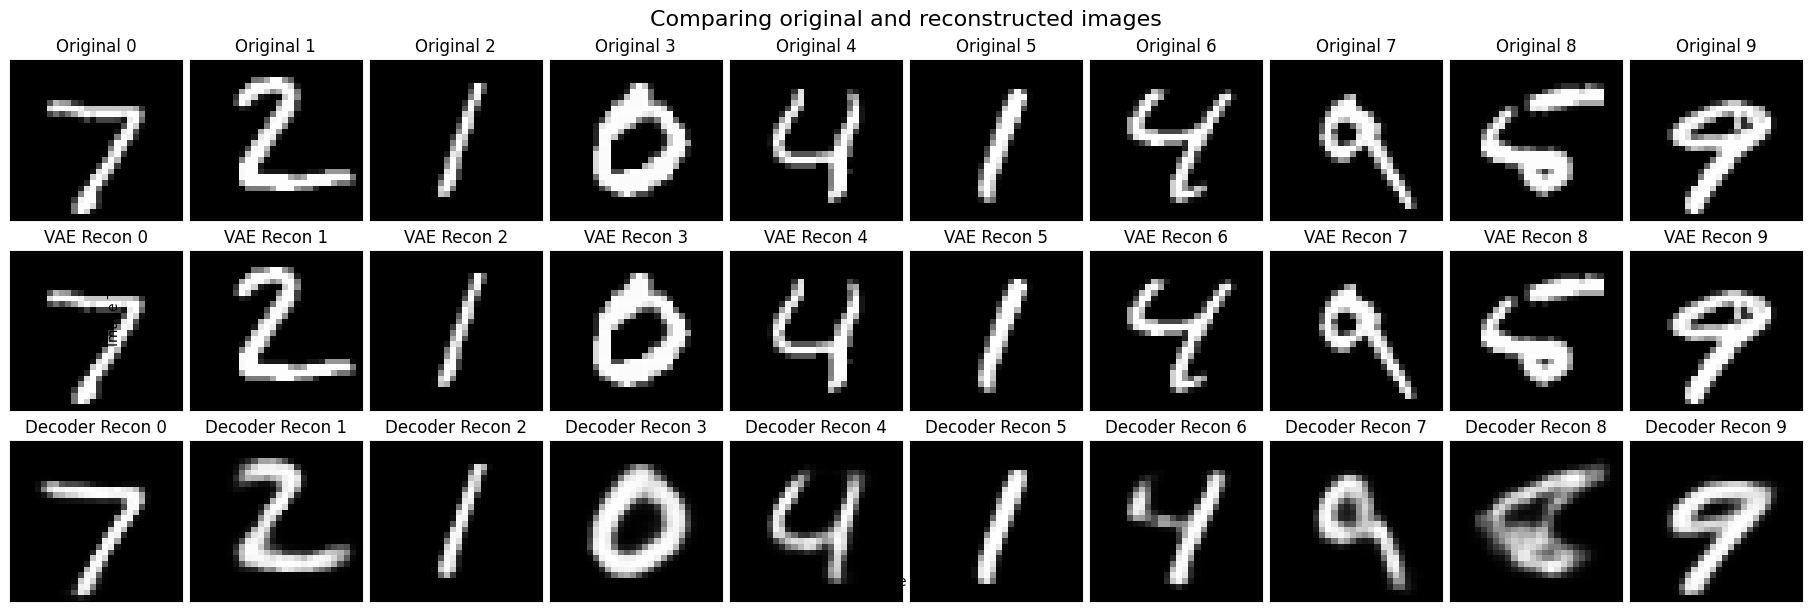

In [ ]:
num_digits = 10
fig, axes = plt.subplots(3, num_digits, figsize=(18, 6), constrained_layout=True)

for i in range(num_digits):

    # Display original
    ax = axes[0, i]
    original_img = x_test[i].reshape(28, 28)
    ax.imshow(original_img, cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Original {i}")

    # Display reconstruction from VAE (encoder+decoder) model
    ax = axes[1, i]
    reconstructed_img_vae = final_vae_model.predict(x_test[i].reshape(1, 28, 28, 1))
    ax.imshow(reconstructed_img_vae.reshape(28, 28), cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"VAE Recon {i}")

    # Display reconstruction from only decoder model
    ax = axes[2, i]
    mu, sigma, z = encoder_model.predict(x_test[i].reshape(1, 28, 28, 1))
    reconstructed_img_decoder = decoder_model.predict(z)
    ax.imshow(reconstructed_img_decoder.reshape(28, 28), cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Decoder Recon {i}")

plt.suptitle("Comparing original and reconstructed images", fontsize=16)
fig.text(0.5, 0.04, 'Image Index', ha='center', va='center')
fig.text(0.06, 0.5, 'Image Type', ha='center', va='center', rotation='vertical')

plt.show()


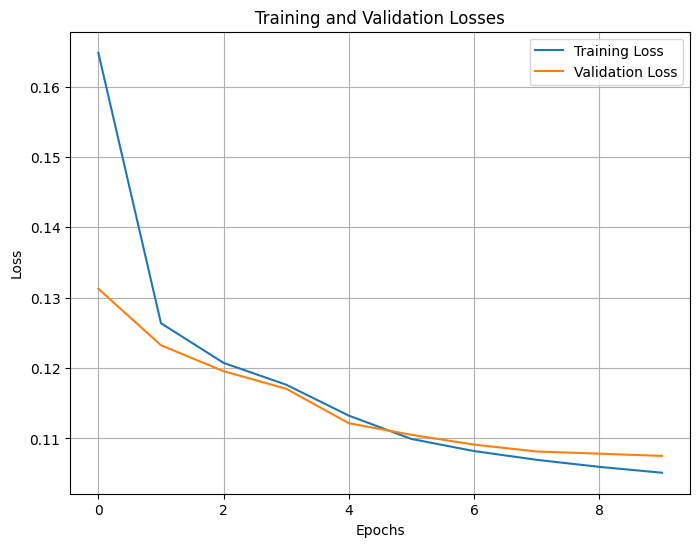

In [ ]:
# plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
